In [7]:
from __future__ import division, print_function
%matplotlib inline
import matplotlib.pyplot as plt

import matplotlib
import numpy as np

In [8]:
from astropy.io import fits


In [9]:
import corner

In [10]:
base_path = "./data/"

# Load simulated image

In [24]:
# Load fits file containing image data
image = fits.getdata(base_path + "0.fits")
print(type(image))
print(image.shape) # each image contains 10,000x10,000 pixels

<class 'numpy.ndarray'>
(10000, 10000)


In [25]:
IMAGE_SIZE = 2000 # Restrict size to 2000 x 2000 pixels

# Normalize image between 0 and 255
X = image[:IMAGE_SIZE, :IMAGE_SIZE]
print(type(X))
X = X-np.min(X)
X = X/np.max(X)*255
print('min/max', np.min(X), np.max(X))

<class 'numpy.ndarray'>
min/max 0.0 255.0


In [38]:
print(type(X))
n = X.size
print(n)
A = X.reshape(n,1)
#A = A.tolist()
A = A.astype(set)
print(type(A))
#print(A)
# Check range of the data. Most pixel values are between 0 and 1
A1 = [i for i in A if i > 1]
print(len(A1), len(A))

<class 'numpy.ndarray'>
4000000
<class 'numpy.ndarray'>


7721 4000000


In [39]:
# Cap values to MAX_VALUE
MAX_VALUE = 50

def indices_2d(a, func):
    return [(ix,iy) for ix, row in enumerate(a) for iy, i in enumerate(row) if func(i)]

inds = indices_2d(X, lambda x: x > 2)
for i,j in inds:
    X[i, j] = MAX_VALUE
print(np.min(X), np.max(X))

0.0 50.0


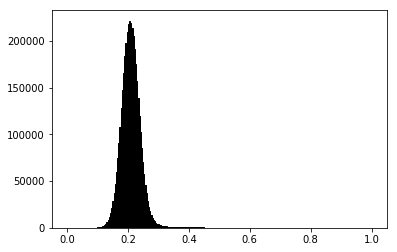

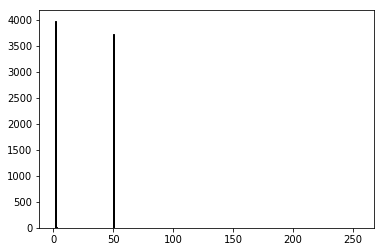

In [48]:
# Plot two histograms, one for values between 0 and 1, and another one from 1 to 255.
plt.hist(X.ravel(), bins=256, range=(0.0, 1.0), fc='k', ec='k')
plt.show()
plt.figure()
plt.hist(X.ravel(), bins=256, range=(1.0, 255.0), fc='k', ec='k')
plt.show()

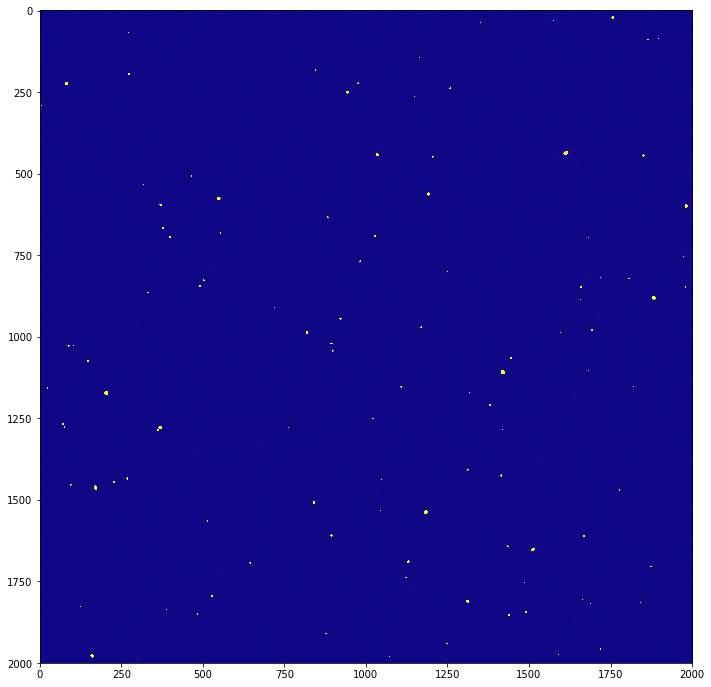

In [54]:
# Display image
fig, ax = plt.subplots(figsize=(12,12))
#ax.imshow(X, cmap="cubehelix", norm=matplotlib.colors.LogNorm())
ax.imshow(X, cmap="plasma")
plt.show()

# Load corresponding groundtruth image

(10000, 10000)


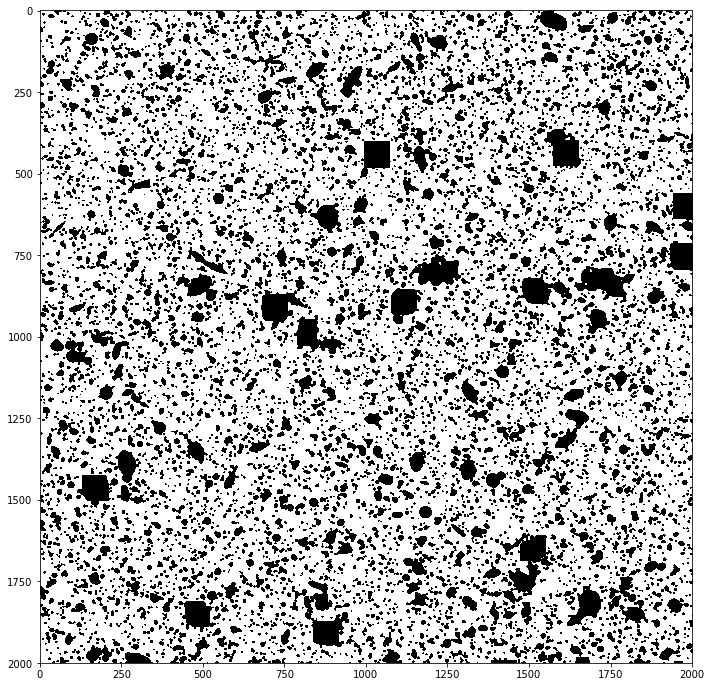

In [56]:
#gt = fits.getdata(base_path + "0.star_seg.fits") # Load groundtruth for stars
#gt = fits.getdata(base_path + "0.gal_seg.fits") # Load groundtruth for galaxies
gt = fits.getdata(base_path + "0.comb_seg.fits") # Load groundtruth for stars and galaxies (not just union of the two)
print(gt.shape) # should be 10,000x10,000

fig, ax = plt.subplots(figsize=(12,12))
ax.imshow(gt[:IMAGE_SIZE, :IMAGE_SIZE], cmap="cubehelix", norm=matplotlib.colors.LogNorm())
plt.show()

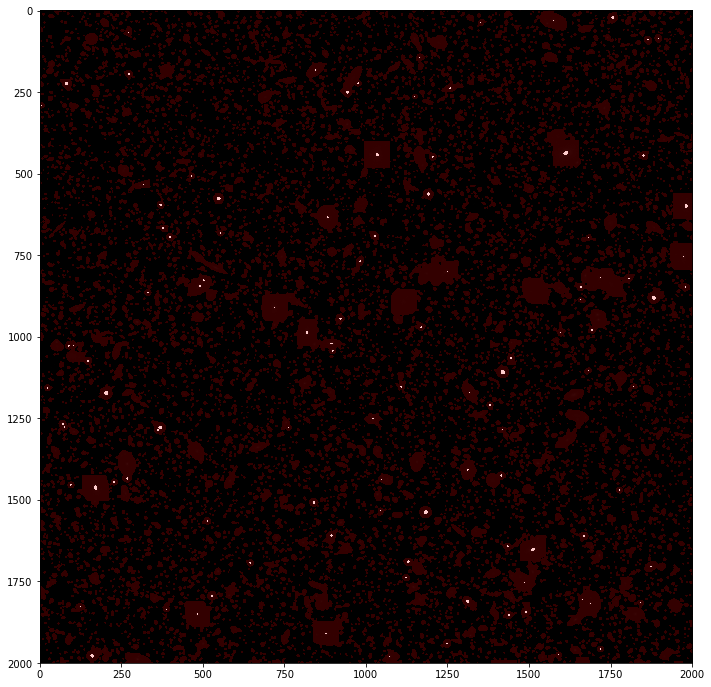

In [58]:
from PIL import Image
PIXEL_DEPTH = 255

def img_float_to_uint8(img):
    rimg = img - np.min(img)
    rimg = (rimg / np.max(rimg) * PIXEL_DEPTH).round().astype(np.uint8)
    return rimg

def make_img_overlay(img, predicted_img):
    w = img.shape[0]
    h = img.shape[1]
    color_mask = np.zeros((w, h, 3), dtype=np.uint8)
    color_mask[:,:,0] = predicted_img*PIXEL_DEPTH

    img8 = img_float_to_uint8(img)
    #background = Image.fromarray(img8, 'RGB').convert("RGBA")
    #overlay = Image.fromarray(color_mask, 'RGB').convert("RGBA")
    background = Image.fromarray(img8).convert("RGBA")
    overlay = Image.fromarray(color_mask).convert("RGBA")    
    new_img = Image.blend(background, overlay, 0.2)
    return new_img

Xo = make_img_overlay(X, gt[:IMAGE_SIZE, :IMAGE_SIZE])
fig, ax = plt.subplots(figsize=(12,12))
ax.imshow(Xo, cmap="plasma", norm=matplotlib.colors.LogNorm())
plt.show()

In [63]:
# You can save the files to a numpy format if you want, just do
for i in range(0,2):
    print(base_path +"testrun"+ str(i) + ".fits")
    image = fits.getdata(base_path + str(i) + ".fits")
    np.save(str(i) + ".npy", image)

./data/testrun1.fits


FileNotFoundError: [Errno 2] No such file or directory: './data/1.fits'

# Catalog

In [69]:
def plot_catalogs(star_data, galaxy_data):
    fig=corner.corner(star_data, color="blue")
    fig=corner.corner(galaxy_data, color="red", labels=("Magnitude", "Size"), extents=[(14, 26), (0,6)], fig=fig)
    plt.show()

## Simulated catalogs ("thruth")

In [73]:
star_catalog = fits.getdata(base_path + "1.star.cat", ext=0)

In [74]:
star_catalog.columns

ColDefs(
    name = 'id'; format = 'K'; disp = 'I10'; dim = 'None'
    name = 'x'; format = 'E'; disp = 'F10.6'; dim = 'None'
    name = 'y'; format = 'E'; disp = 'F10.6'; dim = 'None'
    name = 'mag'; format = 'E'; disp = 'F10.6'; dim = 'None'
    name = 'nphot'; format = 'K'; disp = 'I10'; dim = 'None'
    name = 'psf_r50'; format = 'E'; disp = 'F10.6'; dim = 'None'
    name = 'psf_fwhm'; format = 'E'; disp = 'F10.6'; dim = 'None'
    name = 'psf_e1'; format = 'E'; disp = 'F10.6'; dim = 'None'
    name = 'psf_e2'; format = 'E'; disp = 'F10.6'; dim = 'None'
    name = 'psf_beta'; format = '1E'; disp = 'F10.6'; dim = '(1,)'
)

In [77]:
star_data = np.vstack((star_catalog["mag"], star_catalog["psf_r50"])).T

In [79]:
galaxy_catalog = fits.getdata(base_path + "1.gal.cat")

In [80]:
galaxy_catalog.columns

ColDefs(
    name = 'id'; format = 'K'; disp = 'I10'; dim = 'None'
    name = 'x'; format = 'E'; disp = 'F10.6'; dim = 'None'
    name = 'y'; format = 'E'; disp = 'F10.6'; dim = 'None'
    name = 'z'; format = 'E'; disp = 'F10.6'; dim = 'None'
    name = 'sersic_n'; format = 'E'; disp = 'F10.6'; dim = 'None'
    name = 'nphot'; format = 'K'; disp = 'I10'; dim = 'None'
    name = 'int_r50'; format = 'E'; disp = 'F10.6'; dim = 'None'
    name = 'int_mag'; format = 'E'; disp = 'F10.6'; dim = 'None'
    name = 'int_e1'; format = 'E'; disp = 'F10.6'; dim = 'None'
    name = 'int_e2'; format = 'E'; disp = 'F10.6'; dim = 'None'
    name = 'gamma1'; format = 'E'; disp = 'F10.6'; dim = 'None'
    name = 'gamma2'; format = 'E'; disp = 'F10.6'; dim = 'None'
    name = 'e1'; format = 'E'; disp = 'F10.6'; dim = 'None'
    name = 'e2'; format = 'E'; disp = 'F10.6'; dim = 'None'
    name = 'mag'; format = 'E'; disp = 'F10.6'; dim = 'None'
    name = 'r50'; format = 'E'; disp = 'F10.6'; dim = 'None'
 